In [1]:
!pwd

/Users/kulkarniad/reconstruct_hanle/atmos_experimentation


In [135]:
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d, UnivariateSpline
from astropy.io import fits
from sklearn.cluster import KMeans
import xdrlib

NX = 252
NY = 252
NZ = 64
NLAMBDA = 257

DX = 23.809496

In [79]:
d1 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_t.fits')
d2 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_p.fits')
d3 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_pe.fits')
d4 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_vlos.fits')
d5 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_z.fits')
d6 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_vmic.fits')
d7 = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/sir_rho.fits')

# Throw away bottom of the atmosphere (stuff nan's out beyond log tau = 1.4)

In [80]:
cut_index = 6

cube_t = d1[0].data[:,:,cut_index:NZ]  
cube_p = d2[0].data[:,:,cut_index:NZ] 
cube_pe = d3[0].data[:,:,cut_index:NZ] 
cube_vlos = d4[0].data[:,:,cut_index:NZ] 
cube_z = d5[0].data[:,:,cut_index:NZ] 
cube_vmic = d6[0].data[:,:,cut_index:NZ] 
cube_rho = d7[0].data[:,:,cut_index:NZ] 

In [81]:
def readsim(file):
    raw = np.loadtxt(file)
    return np.transpose(raw.reshape((NZ,NY,NX)))

In [82]:
sim_z = np.loadtxt('/Users/kulkarniad/sir_inversions/2_line_run/z_100.csv') *10.0**(5.0) # cgs units [sim_z is a global value of the simulation domain.]
dx = 23.809496*10.0**(5.0)
dy = 23.809496*10.0**(5.0)

mu = 1.2904  # from rh
kb = 1.38064852*10.0**(-16.0) # cgs 
amu = 1.660540*10**(-24.0) # cgs 
g = 27400.0



In [83]:
sim_tau = np.log10(readsim('/Users/kulkarniad/sir_inversions/2_line_run/tau_100.csv')[:,:,1:])
sim_temp = readsim('/Users/kulkarniad/sir_inversions/2_line_run/t_100.csv')
sim_tau = np.append(np.zeros((NX,NY,1))-6.0,sim_tau,axis=2) ## append log tau = -6 a

In [84]:
A = np.array([1,2,3,4])

In [85]:
A.reshape(2,2)

array([[1, 2],
       [3, 4]])

In [86]:
raw_spectra = np.loadtxt('/Users/kulkarniad/sir_inversions/2_line_run/spectrum.csv')
raw_spectra = np.transpose(raw_spectra.reshape((NLAMBDA,NY,NX)))

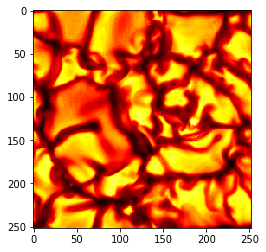

In [87]:
plt.imshow(cube_t[:,:,10],cmap='hot')

In [88]:
tau_sir = np.linspace(1.4,-4.3,num=58) # again we're throwing away the bottom values of tau in SIR inversions

In [89]:
# again we're throwing away the bottom values of tau in SIR inversions

# Now do clustering on spectra

In [90]:
N_CLUSTERS = 5

In [91]:
kmeans_raw = KMeans(n_clusters=N_CLUSTERS,init = 'k-means++' , random_state=5).fit(raw_spectra.reshape((NX*NY,NLAMBDA)))

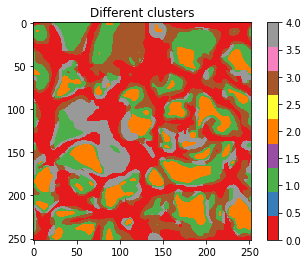

In [92]:
plt.imshow(kmeans_raw.labels_.reshape((NX,NY)),cmap='Set1')
plt.colorbar()
plt.title('Different clusters')
plt.show()

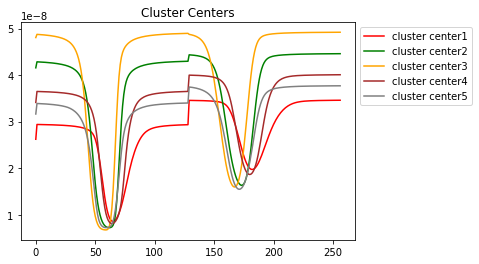

In [93]:
colors = ['red','green', 'orange', 'brown','grey']
for i in np.arange(N_CLUSTERS):
    plt.plot(kmeans_raw.cluster_centers_[i],label = 'cluster center' + str(i+1),color = colors[i])
    plt.legend()
plt.title('Cluster Centers')
plt.legend(bbox_to_anchor=(1, 0, 0, 1))

# Construct average z vs tau for each cluster

In [94]:
tau_clusters = np.zeros((N_CLUSTERS,NZ))
cluster_labels = kmeans_raw.labels_.reshape((NX,NY))
counts = np.zeros(N_CLUSTERS)

for i in range(N_CLUSTERS):
    counts[i] = np.count_nonzero(kmeans_raw.labels_.flatten() == i)


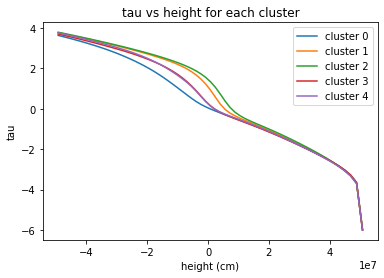

In [95]:
# add up tau profiles acoording to cluster classification
for i in range(NX):
    for j in range(NY):
        for c in range(N_CLUSTERS):
            if cluster_labels[i,j] == c:
                tau_clusters[c] += sim_tau[i,j,:]


# divide by number of pixels in each class and plot:
for c in range(N_CLUSTERS):
    tau_clusters[c] /= counts[c]
    plt.plot(sim_z,tau_clusters[c],label = 'cluster ' + str(c))
plt.legend()
plt.xlabel('height (cm)')
plt.ylabel('tau')
plt.title('tau vs height for each cluster')
plt.show()

# Now interpolate the entire SIR cube

In [96]:
# create interpolating functions for tau(z)
tau_z = []
for c in range(N_CLUSTERS):
    function = interp1d((1e-5)*sim_z[:],tau_clusters[c],kind='linear',fill_value='extrapolate')
    tau_z.append(function)

In [97]:
recons_temp = np.zeros((NX,NY,NZ))  
recons_vlos = np.zeros((NX,NY,NZ))  
recons_p = np.zeros((NX,NY,NZ))  
recons_pe = np.zeros((NX,NY,NZ))  
recons_vmic = np.zeros((NX,NY,NZ))  
recons_rho = np.zeros((NX,NY,NZ))  

for i in range(NX):
    for j in range(NY):
        #STEP 1: interpolate physical paramters onto tau scale for each pixel:
        # Try log interpolation if it doesn't work well...
        temp_tau = interp1d(tau_sir,cube_t[i,j,:],fill_value='extrapolate') 
        vlos_tau = interp1d(tau_sir,cube_vlos[i,j,:],fill_value='extrapolate') 
        p_tau = interp1d(tau_sir,cube_p[i,j,:],fill_value='extrapolate') 
        pe_tau = interp1d(tau_sir,cube_pe[i,j,:],fill_value='extrapolate') 
        vmic_tau =  interp1d(tau_sir,cube_vmic[i,j,:],fill_value='extrapolate') 
        rho_tau = interp1d(tau_sir,cube_rho[i,j,:],fill_value='extrapolate') 

        # STEP2: Now fill in pixels with interpolated values
        for c in range(N_CLUSTERS):
            #print(c)
            #print(cluster_labels[i,j] == c)
            if cluster_labels[i,j] == c:
                recons_temp[i,j] = temp_tau(tau_z[c](sim_z*(1e-5)))
                recons_vlos[i,j] = vlos_tau(tau_z[c](sim_z*(1e-5)))
                recons_p[i,j] = p_tau(tau_z[c](sim_z*(1e-5)))
                recons_pe[i,j] = pe_tau(tau_z[c](sim_z*(1e-5)))
                recons_rho[i,j] = rho_tau(tau_z[c](sim_z*(1e-5)))

# Now clean things up a bit

In [98]:
#Calculate derived quantites and put into RH units:
recons_nh = recons_rho/(mu*amu)*(1e6)
recons_vz = recons_vlos*(1e-5)*(-1.0)
recons_nelec = recons_pe/(recons_temp*kb)*(1e6)
recons_vmic *= (1e-5)

#set thresholds

recons_temp[recons_temp < 4500.0] = 4500.0
recons_temp[recons_temp > 15000.0] = 15000.0

recons_nh[recons_nh < 1e21] =  1e21
recons_nh[recons_nh > 1e23] =  1e23

recons_nelec[recons_nelec < 1e17] =  1e17
recons_nelec[recons_nelec > 1e23] =  1e23

recons_vz[recons_vz < -15.0] =  -15.0
recons_vz[recons_vz > 15.0] =  15.0

# Apply a horizontal gaussian filter in the atmosphere:


smoothing = 3

recons_temp = gaussian_filter(recons_temp,(smoothing,smoothing,0)).transpose()
recons_vz = gaussian_filter(recons_vz,(smoothing,smoothing,0)).transpose()
recons_p = gaussian_filter(recons_p,(smoothing,smoothing,0)).transpose()
recons_nelec = gaussian_filter(recons_nelec,(smoothing,smoothing,0)).transpose()
recons_vmic = gaussian_filter(recons_vmic,(smoothing,smoothing,0)).transpose()
recons_nh = gaussian_filter(recons_nh,(smoothing,smoothing,0)).transpose()



# Let's compare this to the original muram atmosphere:

In [99]:
#load in MURAM data
awd = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/rh_nh.fits')
rh_nh = awd[0].data

awd = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/rh_nelec.fits')
rh_nelec = awd[0].data

awd = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/rh_t.fits')
rh_temp = awd[0].data

awd = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/rh_vz.fits')
rh_vz = awd[0].data


In [100]:
def compare(sim,recon,k_index):
    wl_flag = 0
    neg_flag = 0

    if sim.shape == (NLAMBDA,NZ,NY,NX):
        sim = sim[lc]  #look at line center wavelength
        recon = recon[lc] #look at line center wavelength

    if np.min(sim) <= 0.0:
        neg_flag = 1

    if neg_flag == 1:
        plt.figure(figsize=(20,20))
        plt.subplot(121)
        plt.title('Simulation')
        plt.imshow(sim[k_index],cmap='bwr')
        up = np.max(np.abs(sim[k_index])) * 1.2
        plt.clim(-up,up)
        plt.colorbar()
        plt.subplot(122)
        plt.title('Reconstruction')
        plt.imshow(recon[k_index],cmap='bwr')
        plt.clim(-up,up)
        plt.colorbar()
        plt.show()

    if neg_flag == 0:
        plt.figure(figsize=(20,20))
        plt.subplot(121)
        plt.title('Simulation')

        plt.imshow(sim[k_index],cmap='hot')
        up = np.max(sim[k_index]) * 1.2
        lo = np.min(sim[k_index])* 0.8
        plt.clim(lo,up)
        plt.colorbar()

        plt.subplot(122)
        plt.title('Reconstruction')

        plt.imshow(recon[k_index],cmap='hot')
        plt.clim(lo,up)
        plt.colorbar()
        plt.show()

317.5255432128906


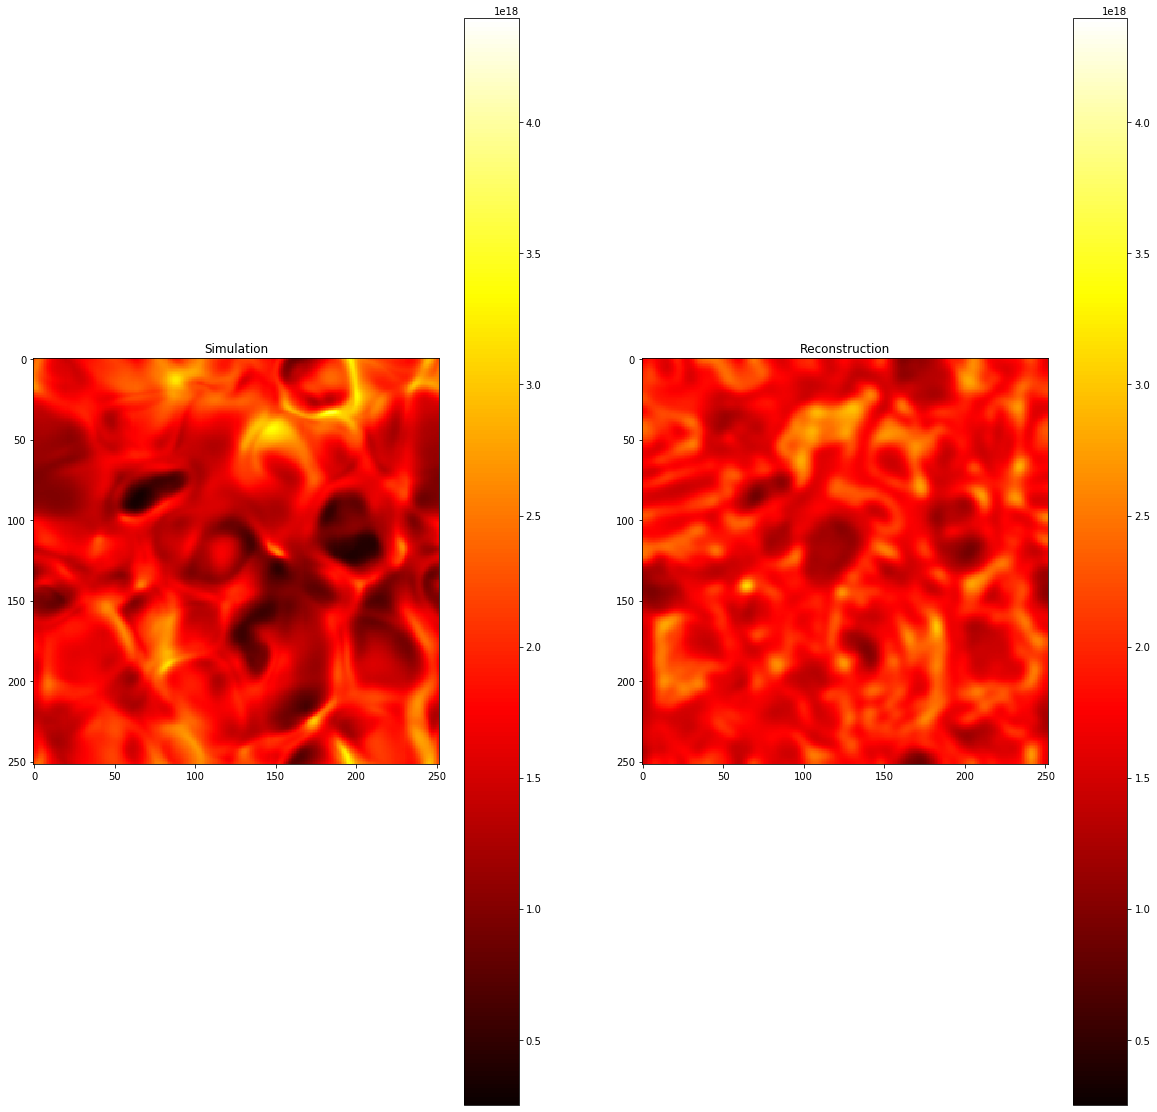

In [114]:
k = 10
print(sim_z[k]*1e-5)
compare(rh_nelec,recons_nelec,k)


In [404]:
hdu = fits.PrimaryHDU(recons_temp)
hdu.writeto('recons_temp.fits',overwrite = True)

hdu = fits.PrimaryHDU(recons_nh)
hdu.writeto('recons_nh.fits',overwrite = True)

hdu = fits.PrimaryHDU(recons_nelec)
hdu.writeto('recons_nelec.fits',overwrite = True)

hdu = fits.PrimaryHDU(recons_vz)
hdu.writeto('recons_vz.fits',overwrite = True)

hdu = fits.PrimaryHDU(recons_vmic)
hdu.writeto('recons_vmic.fits',overwrite = True)

# Everything looks good, write the atmosphere

In [141]:
# NOTE(cmo): Prep all the parameters for the atmosphere (here a 4x4xFALC_82)
NHydr = 1
cut = 50

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vx = np.zeros((NZ, cut, cut))
vy = np.zeros((NZ, cut, cut))
vmic = np.zeros((NZ, cut, cut))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(cut)
p.pack_int(cut)
p.pack_int(NZ)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(DX)
p.pack_double(DX)

p.pack_farray(NZ, sim_z*(1e-5), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_temp[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_nelec[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vmic.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vx.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vy.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_vz[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NHydr*NZ*cut*cut, recons_nh[:,0:cut,0:cut].flatten(), p.pack_double)

! rm 'smooth_reconstruct.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('smooth_reconstruct.atmos', 'wb') as f:
    f.write(p.get_buffer()) 


# Manually view oututs

In [314]:
recons_i = fits.open('/Users/kulkarniad/rh_aniso/rhsc3d/reconstruct_vertical/i.fits')[0].data
sim_i = fits.open('/Users/kulkarniad/rh_aniso/rhsc3d/small_vertical/i.fits')[0].data

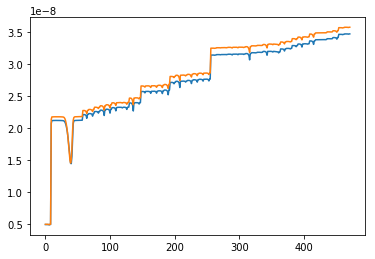

In [327]:
i = np.random.randint(50)
j = np.random.randint(50)

plt.plot(sim_i[:,i,j],label = 'sim')
plt.plot(recons_i[:,i,j],label = 'recons')

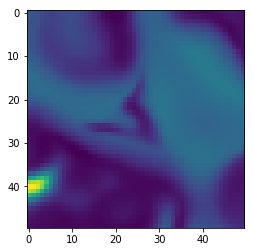

In [313]:
plt.imshow(recons_i[30])

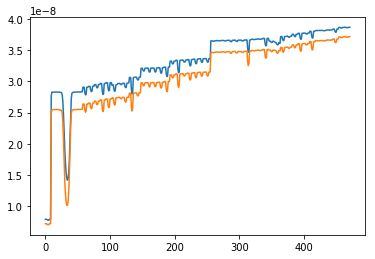

In [247]:
i = np.random.randint(10)
j = np.random.randint(10)


plt.plot(sim_i[:,i,j])
plt.plot(recons_i[:,i,j])



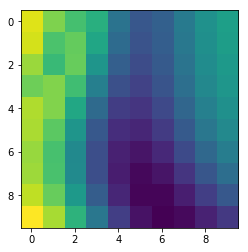

In [207]:
plt.imshow(recons_i[30])

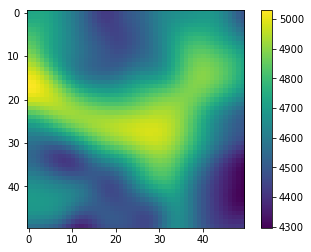

In [262]:
plt.imshow(new_t[10])
plt.colorbar()

# More atmos comparison

In [361]:
class Atmos:
    def __init__(self,fname):
        data = fits.open(fname)
        a = data[1].data[0]
        self.nx = a[0]
        self.ny = a[1]
        self.nz = a[2]
        self.nhydr = a[3]
        self.bcs = a[4]
        self.dx = a[5]
        self.dy = a[6]
        self.z = a[7]
        self.t = a[8]
        self.nelec = a[9]
        self.vturb = a[10]
        self.vx = a[11]
        self.vy = a[12]
        self.vz = a[13]
        self.nh = a[14]

In [362]:
recons = Atmos('/Users/kulkarniad/rh_aniso/rhsc3d/smooth_reconstruct/reconstruct.fits')
sim = Atmos('/Users/kulkarniad/muram/small.fits')

In [356]:
temp = recons[0][8]

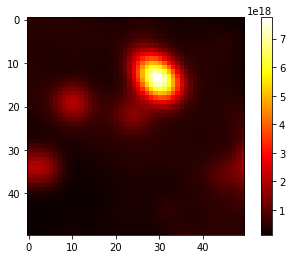

In [389]:
plt.imshow(recons.nelec[3],cmap='hot')
plt.colorbar()

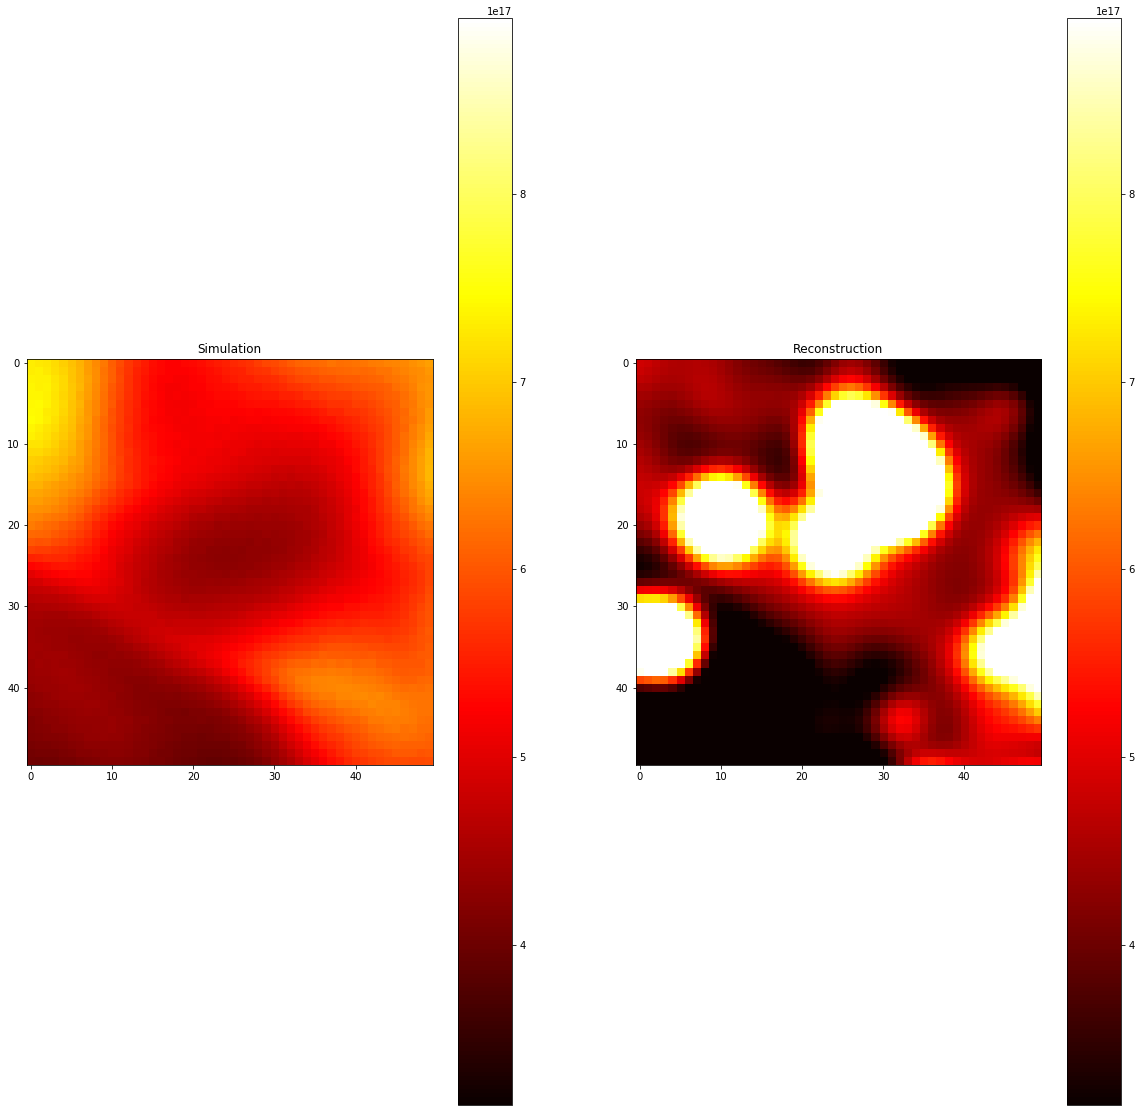

In [387]:
compare(sim.nelec,recons.nelec,3)

# Let's try cheating a bit and using the temperature from the inversion but the tau(z) mapping from the simulation. So we're just playing with half the battle here

In [157]:
recons_temp = np.zeros((NX,NY,NZ))  
recons_vlos = np.zeros((NX,NY,NZ))  
recons_p = np.zeros((NX,NY,NZ))  
recons_pe = np.zeros((NX,NY,NZ))  
recons_vmic = np.zeros((NX,NY,NZ))  
recons_rho = np.zeros((NX,NY,NZ))  

for i in range(NX):
    for j in range(NY):
        #STEP 1: interpolate physical paramters onto tau scale for each pixel:
        # Try log interpolation if it doesn't work well...
        temp_tau = interp1d(tau_sir,cube_t[i,j,:],fill_value='extrapolate') 
        vlos_tau = interp1d(tau_sir,cube_vlos[i,j,:],fill_value='extrapolate') 
        p_tau = interp1d(tau_sir,cube_p[i,j,:],fill_value='extrapolate') 
        pe_tau = interp1d(tau_sir,cube_pe[i,j,:],fill_value='extrapolate') 
        vmic_tau =  interp1d(tau_sir,cube_vmic[i,j,:],fill_value='extrapolate') 
        rho_tau = interp1d(tau_sir,cube_rho[i,j,:],fill_value='extrapolate') 
        
        # create tau(z) interpolating function for that individual pixel        
        tau_z = interp1d(sim_z*(1e-5),sim_tau[i,j,:],fill_value='extrapolate')
        

        recons_temp[i,j] = temp_tau(tau_z(sim_z*(1e-5)))
        recons_vlos[i,j] = vlos_tau(tau_z(sim_z*(1e-5)))
        recons_p[i,j] = p_tau(tau_z(sim_z*(1e-5)))
        recons_pe[i,j] = pe_tau(tau_z(sim_z*(1e-5)))
        recons_rho[i,j] = rho_tau(tau_z(sim_z*(1e-5)))

        
        
        
        # create tau(z) interpolating function for that individual pixel

In [158]:
#Calculate derived quantites and put into RH units:
recons_nh = recons_rho/(mu*amu)*(1e6)
recons_vz = recons_vlos*(1e-5)*(-1.0)
recons_nelec = recons_pe/(recons_temp*kb)*(1e6)
recons_vmic *= (1e-5)

#set thresholds

recons_temp[recons_temp < 4500.0] = 4500.0
recons_temp[recons_temp > 15000.0] = 15000.0

recons_nh[recons_nh < 1e21] =  1e21
recons_nh[recons_nh > 1e23] =  1e23

recons_nelec[recons_nelec < 1e17] =  1e17
recons_nelec[recons_nelec > 1e23] =  1e23

recons_vz[recons_vz < -15.0] =  -15.0
recons_vz[recons_vz > 15.0] =  15.0

# Apply a horizontal gaussian filter in the atmosphere:


smoothing = 3

recons_temp = gaussian_filter(recons_temp,(smoothing,smoothing,0)).transpose()
recons_vz = gaussian_filter(recons_vz,(smoothing,smoothing,0)).transpose()
recons_p = gaussian_filter(recons_p,(smoothing,smoothing,0)).transpose()
recons_nelec = gaussian_filter(recons_nelec,(smoothing,smoothing,0)).transpose()
recons_vmic = gaussian_filter(recons_vmic,(smoothing,smoothing,0)).transpose()
recons_nh = gaussian_filter(recons_nh,(smoothing,smoothing,0)).transpose()



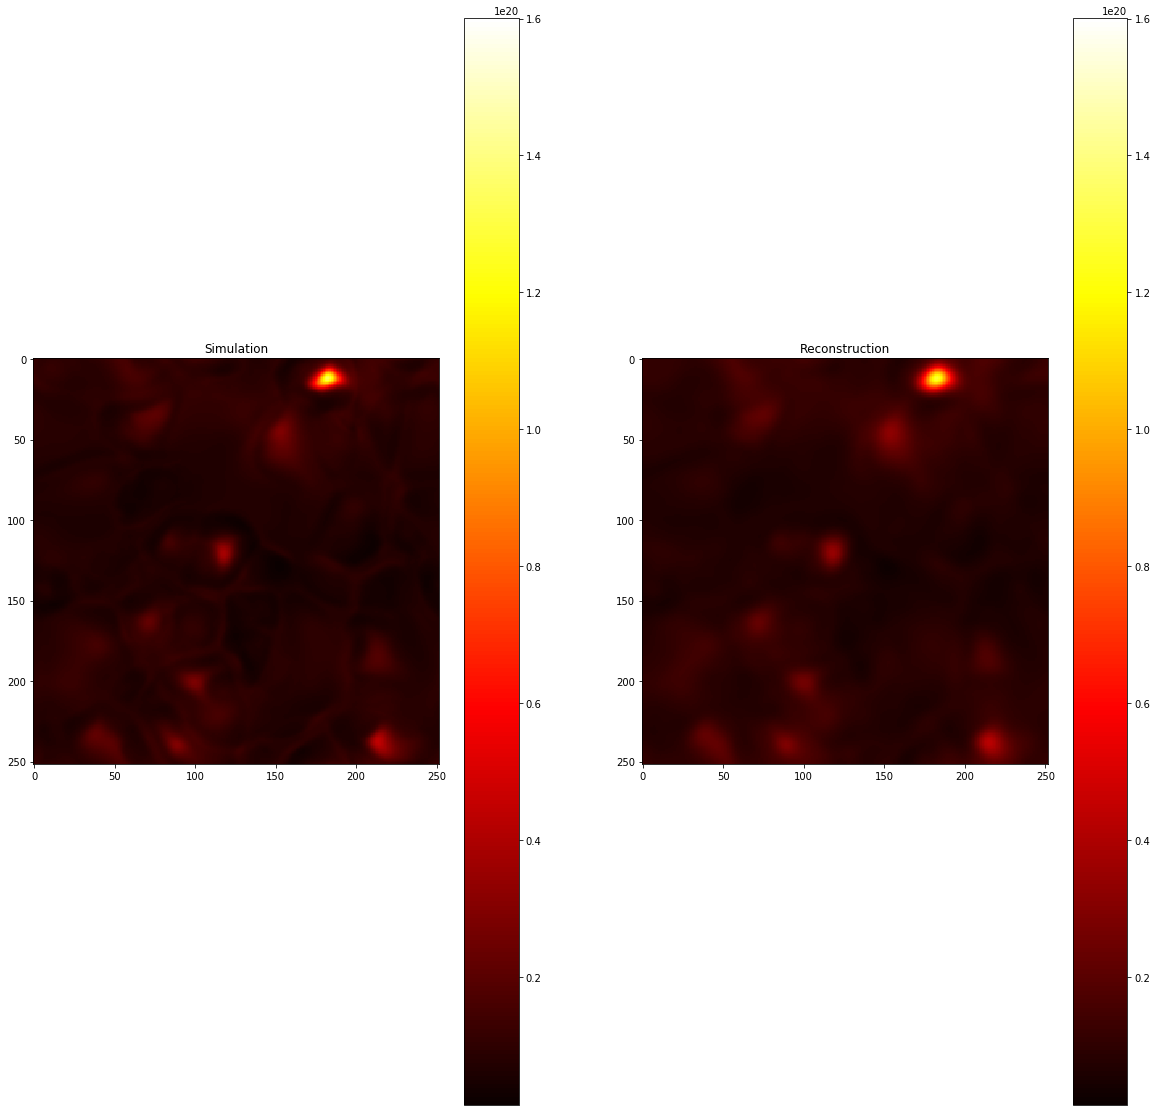

In [159]:
compare(rh_nelec,recons_nelec,20)

In [160]:
hdu = fits.PrimaryHDU(recons_temp)
hdu.writeto('recons_temp_truetau.fits',overwrite = True)

hdu = fits.PrimaryHDU(recons_nh)
hdu.writeto('recons_nh_truetau.fits',overwrite = True)

hdu = fits.PrimaryHDU(recons_nelec)
hdu.writeto('recons_nelec_truetau.fits',overwrite = True)

hdu = fits.PrimaryHDU(recons_vz)
hdu.writeto('recons_vz_truetau.fits',overwrite = True)

hdu = fits.PrimaryHDU(recons_vmic)
hdu.writeto('recons_vmic_truetau.fits',overwrite = True)

# Looks good now write the atmosphere

In [161]:
# NOTE(cmo): Prep all the parameters for the atmosphere (here a 4x4xFALC_82)
NHydr = 1
cut = 50

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vx = np.zeros((NZ, cut, cut))
vy = np.zeros((NZ, cut, cut))
vmic = np.zeros((NZ, cut, cut))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(cut)
p.pack_int(cut)
p.pack_int(NZ)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(DX)
p.pack_double(DX)

p.pack_farray(NZ, sim_z*(1e-5), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_temp[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_nelec[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vmic.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vx.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vy.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_vz[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NHydr*NZ*cut*cut, recons_nh[:,0:cut,0:cut].flatten(), p.pack_double)

! rm 'smooth_reconstruct_truetau.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('smooth_reconstruct_truetau.atmos', 'wb') as f:
    f.write(p.get_buffer()) 


rm: smooth_reconstruct_truetau.atmos: No such file or directory


# Now use simulation temperatures/densities but used clustered tau(z) mapping

In [165]:
#load in MURAM data
awd = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/rh_nh.fits')
sim_nh = awd[0].data

awd = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/rh_nelec.fits')
sim_nelec = awd[0].data

awd = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/rh_t.fits')
sim_temp = awd[0].data

awd = fits.open('/Users/kulkarniad/sir_inversions/2_line_run/rh_vz.fits')
sim_vz = awd[0].data

In [166]:
sim_temp.shape

(64, 252, 252)

In [167]:
sim_tau.shape

(252, 252, 64)

In [169]:
# create interpolating functions for tau(z)
tau_z = []
for c in range(N_CLUSTERS):
    function = interp1d((1e-5)*sim_z[:],tau_clusters[c],kind='linear',fill_value='extrapolate')
    tau_z.append(function)

In [171]:
recons_temp = np.zeros((NX,NY,NZ))  
recons_vz = np.zeros((NX,NY,NZ))  
recons_nh = np.zeros((NX,NY,NZ))  
recons_nelec = np.zeros((NX,NY,NZ))  

for i in range(NX):
    for j in range(NY):
        #STEP 1: interpolate physical paramters onto tau scale for each pixel:
        # Try log interpolation if it doesn't work well...
        
        temp_tau = interp1d(sim_tau[i,j],sim_temp[:,i,j],fill_value='extrapolate') 
        vz_tau = interp1d(sim_tau[i,j],sim_vz[:,i,j],fill_value='extrapolate') 
        nelec_tau = interp1d(sim_tau[i,j],sim_nelec[:,i,j],fill_value='extrapolate') 
        nh_tau = interp1d(sim_tau[i,j],sim_nh[:,i,j],fill_value='extrapolate') 

        # STEP2: Now fill in pixels with interpolated values
        for c in range(N_CLUSTERS):
            #print(c)
            #print(cluster_labels[i,j] == c)
            if cluster_labels[i,j] == c:
                recons_temp[i,j] = temp_tau(tau_z[c](sim_z*(1e-5)))
                recons_vz[i,j] = vz_tau(tau_z[c](sim_z*(1e-5)))
                recons_nh[i,j] = nh_tau(tau_z[c](sim_z*(1e-5)))
                recons_nelec[i,j] = nelec_tau(tau_z[c](sim_z*(1e-5)))

# transpose arrays:

smoothing = 2
recons_temp = gaussian_filter(recons_temp,(smoothing,smoothing,0)).transpose(2,0,1)
recons_vz = gaussian_filter(recons_vz,(smoothing,smoothing,0)).transpose(2,0,1)
recons_nelec = gaussian_filter(recons_nelec,(smoothing,smoothing,0)).transpose(2,0,1)
recons_nh = gaussian_filter(recons_nh,(smoothing,smoothing,0)).transpose(2,0,1)



#recons_temp = recons_temp.transpose(2,0,1)
#recons_vz = recons_vz.transpose()
#recons_nh = recons_nh.transpose()
#recons_nelec = recons_nelec.transpose()

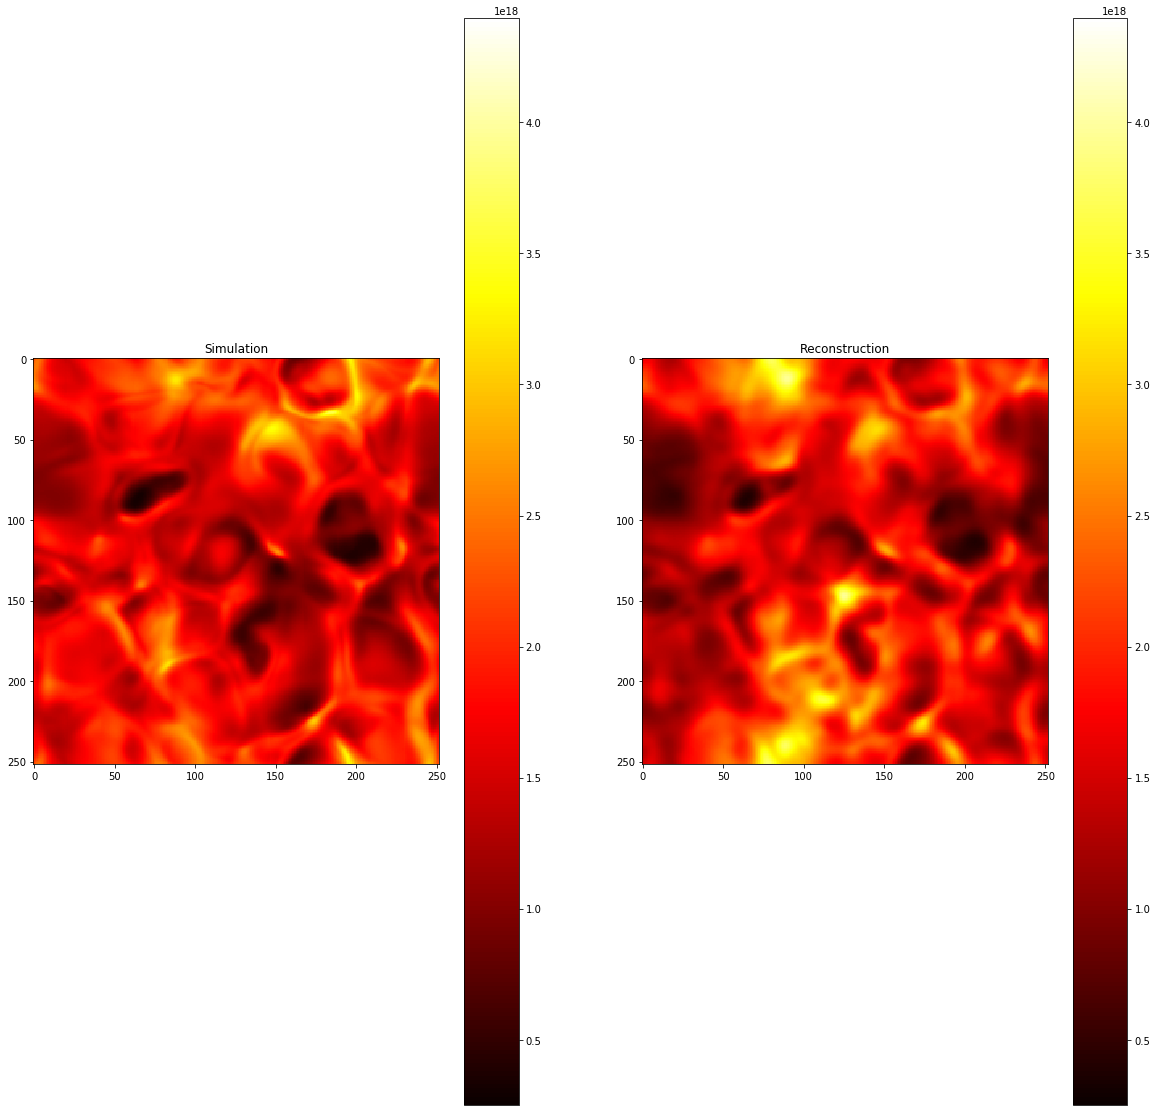

In [179]:
compare(rh_nelec,recons_nelec,10)

# Looks good now write the atmosphere

In [180]:
# NOTE(cmo): Prep all the parameters for the atmosphere (here a 4x4xFALC_82)
NHydr = 1
cut = 50

BcIrradiated = 0
BcZero = 1
BcThermalised = 2

upperBc = BcZero
lowerBc = BcThermalised

vx = np.zeros((NZ, cut, cut))
vy = np.zeros((NZ, cut, cut))
vmic = np.zeros((NZ, cut, cut))


# NOTE(cmo): Pack the data into an xdrlib Packer
p = xdrlib.Packer()
p.pack_int(cut)
p.pack_int(cut)
p.pack_int(NZ)
p.pack_int(NHydr)
p.pack_int(upperBc)
p.pack_int(lowerBc)

p.pack_double(DX)
p.pack_double(DX)

p.pack_farray(NZ, sim_z*(1e-5), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_temp[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_nelec[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vmic.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vx.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, vy.flatten(), p.pack_double)
p.pack_farray(NZ*cut*cut, recons_vz[:,0:cut,0:cut].flatten(), p.pack_double)
p.pack_farray(NHydr*NZ*cut*cut, recons_nh[:,0:cut,0:cut].flatten(), p.pack_double)

! rm 'smooth_reconstruct_truetemp.atmos'
# NOTE(cmo): Dump the packer's data into a binary file
with open('smooth_reconstruct_truetemp.atmos', 'wb') as f:
    f.write(p.get_buffer()) 


rm: smooth_reconstruct_truetemp.atmos: No such file or directory
